# Test influence of hyperparameters in the linear initialization

We want to understand how the hyperparameters (regularization parameter, number of iterations, convergence tolerence, tolerance for dropping spikes or merging them) used in the linear initialization step impact the recovery.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pointscat.forward_problem import angle_to_vec, PointScatteringProblem, compute_far_field
from pointscat.inverse_problem import unif_sample_disk, DiscreteMeasure, solve_blasso


np.random.seed(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Setting problem

In [2]:
amplitudes = np.array([0.5, 2, 1])
locations = np.array([[-3.3, -3.7], [-2.8, 3.5], [3.2, 2.6]])
wave_number = 1
point_scat = PointScatteringProblem(locations, amplitudes, wave_number)

In [3]:
def plot_result(locations, amplitudes, estimated_measure, box_size):
    fig = plt.figure(figsize=(5, 5))

    ax = fig.add_subplot(1, 1, 1, projection='3d')

    markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes)

    stemlines.set_color('black')
    markerline.set_color('black')
    baseline.set_linestyle('none')

    markerline, stemlines, baseline = ax.stem(estimated_measure.locations[:, 0],
                                              estimated_measure.locations[:, 1],
                                              estimated_measure.amplitudes)

    stemlines.set_color('red')
    markerline.set_color('red')
    baseline.set_linestyle('none')

    ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
    ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)

    fig.tight_layout()
    plt.show()

Far field computation

In [4]:
box_size = 10  # locations should belong to (-box_size/2,box_size/2)
num_frequencies = 50
cutoff_frequency = 2 * wave_number
frequencies = unif_sample_disk(num_frequencies, cutoff_frequency)

incident_angles = np.array([np.pi + np.angle(k[0]+1j*k[1]) - np.arccos(np.linalg.norm(k)/(2*wave_number))
                            for k in frequencies])
observation_directions = np.array([np.angle(k[0]+1j*k[1]) + np.arccos(np.linalg.norm(k)/(2*wave_number))
                                   for k in frequencies])

far_field = point_scat.compute_far_field(incident_angles, observation_directions)
far_field_born = point_scat.compute_far_field(incident_angles, observation_directions, born_approx=True)

Relative L2 error between true far field and Born approximation

In [5]:
print(np.linalg.norm(far_field - far_field_born) / np.linalg.norm(far_field))

0.1174604170427251


### Linear initialization **assuming the number of spikes is known**

In [6]:
reg_param = 0.5
num_iter = 3

obs = np.concatenate([np.real(far_field), -np.imag(far_field)])
estimated_measure = solve_blasso(frequencies, obs, reg_param, num_iter, box_size, convergence_tol=1e-2)

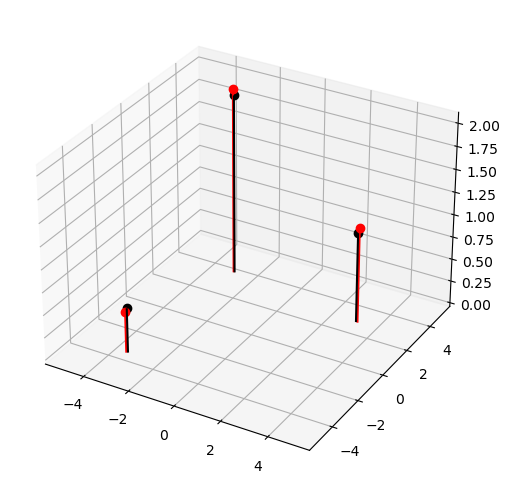

In [7]:
plot_result(locations, amplitudes, estimated_measure, box_size)

Nonlinear local optimization

In [8]:
estimated_measure.perform_nonlinear_sliding(incident_angles, observation_directions, obs, wave_number, box_size)

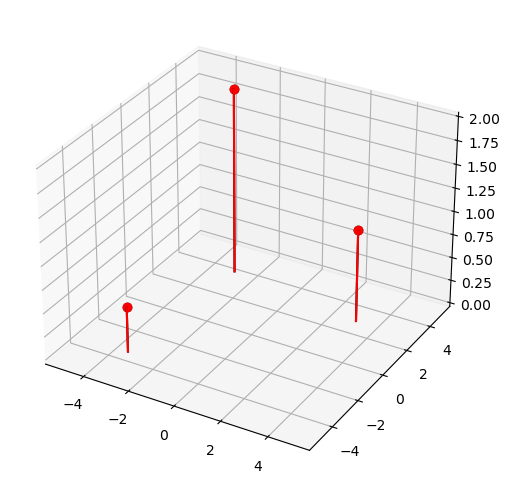

In [9]:
plot_result(locations, amplitudes, estimated_measure, box_size)

### Linear initialization **assuming the number of spikes is not known and without merging or dropping spikes**

**Kernel dies when num_iter set to 10. TODO: try again (there was a bug regarding amplitudes before)**

In [10]:
reg_param = 0.5
num_iter = 5

obs = np.concatenate([np.real(far_field), -np.imag(far_field)])
estimated_measure = solve_blasso(frequencies, obs, reg_param, num_iter, box_size, convergence_tol=1e-2)

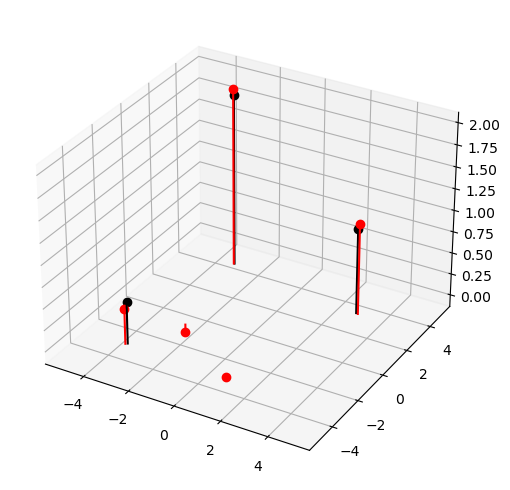

In [11]:
plot_result(locations, amplitudes, estimated_measure, box_size)

Nonlinear local optimization

In [12]:
estimated_measure.perform_nonlinear_sliding(incident_angles, observation_directions, obs, wave_number, box_size)

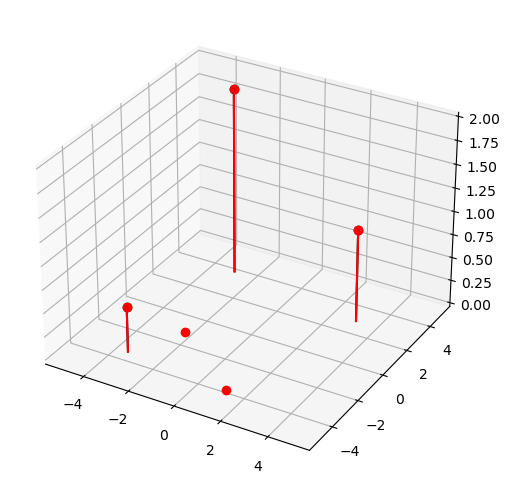

In [13]:
plot_result(locations, amplitudes, estimated_measure, box_size)

### Linear initialization **assuming the number of spikes is not known and with merging or dropping spikes**

In [14]:
reg_param = 0.5
num_iter = 10

obs = np.concatenate([np.real(far_field), -np.imag(far_field)])
estimated_measure = solve_blasso(frequencies, obs, reg_param, num_iter, box_size, convergence_tol=1e-2,
                                 tol_locations=0.1, tol_amplitudes=0.1)

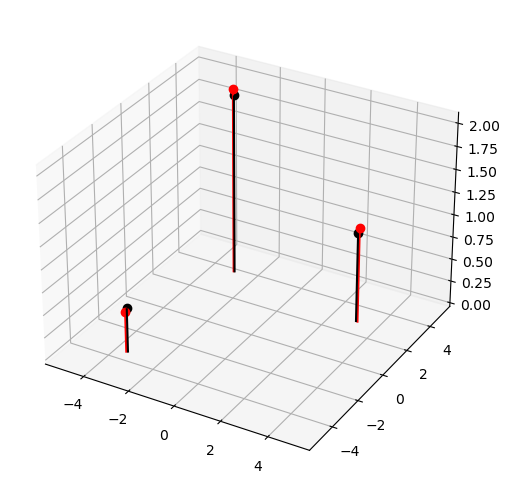

In [15]:
plot_result(locations, amplitudes, estimated_measure, box_size)

In [16]:
estimated_measure.perform_nonlinear_sliding(incident_angles, observation_directions, obs, wave_number, box_size,
                                            tol_locations=0.1, tol_amplitudes=0.1)

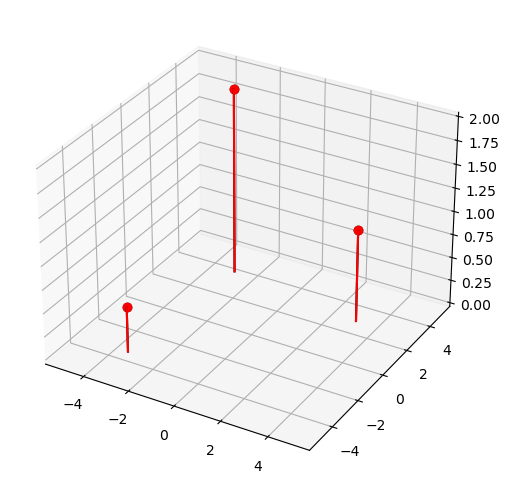

In [17]:
plot_result(locations, amplitudes, estimated_measure, box_size)

**Question: how to set automatically tol_locations and tol_amplitudes?**

In [18]:
reg_param = 0.5
num_iter = 7

obs = np.concatenate([np.real(far_field), -np.imag(far_field)])
estimated_measure = solve_blasso(frequencies, obs, reg_param, num_iter, box_size, convergence_tol=1e-2,
                                 tol_locations=0.1, tol_amplitudes=0.01)

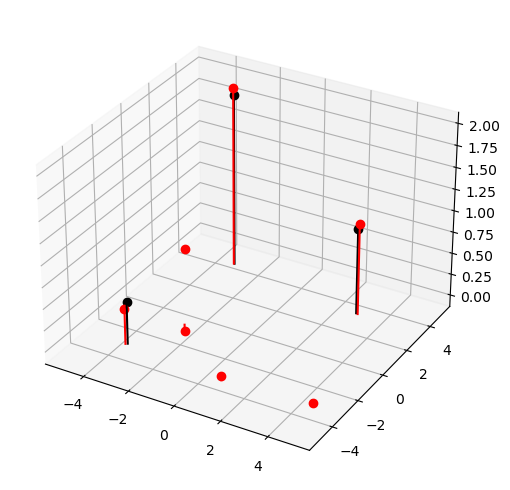

In [19]:
plot_result(locations, amplitudes, estimated_measure, box_size)

In [20]:
estimated_measure.perform_nonlinear_sliding(incident_angles, observation_directions, obs, wave_number, box_size,
                                            tol_locations=0.1, tol_amplitudes=0.01)

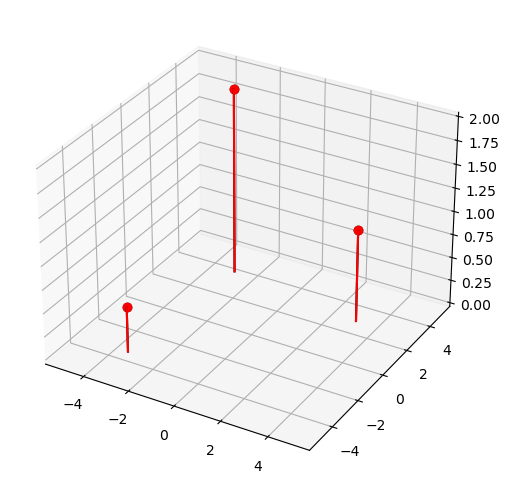

In [21]:
plot_result(locations, amplitudes, estimated_measure, box_size)

**Output now does not seem too sensitive to choice of parameters...**